<div align='center'>

# Artificial Neural Networks - Part 2

### Part of Scientific-ML-Notes 

[![GitHub](https://img.shields.io/badge/GitHub-Repository-black?logo=github&scale=5)](https://github.com/mhnaderi/Scientific-ML-Notes)

---

In [2]:
#! Always run this cell first to import all necessary libraries and to set up the notebook environment

! pip install -q flax
! pip install -q optax
! pip install -q equinox
! pip install -q jaxtyping
! pip install -q torch torchvision

import numpy as np

import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as random
from flax import linen as nn
from jaxtyping import Array, Float, Int, PyTree 

import optax 
import equinox as eqx
import torch, torchvision

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({"font.family": "serif"})
plt.rcParams.update({"figure.facecolor": 'white', "axes.facecolor": 'white'})

# Convolutional Neural Networks (CNNs)

Convolutional Neural Networks (CNNs) are specialized deep learning models designed to process data with a grid-like topology, such as images. They have become the cornerstone of computer vision tasks due to their ability to capture spatial hierarchies and patterns in data. This comprehensive explanation delves into the motivations behind CNNs, their fundamental operations, and the architectural components that make them effective.

## Motivations for CNNs in Image Processing

Images possess unique characteristics that necessitate specialized architectures beyond traditional fully connected neural networks:

1. **High Dimensionality**: Images are high-dimensional data. For example, a standard RGB image of size $224 \times 224$ pixels contains $224 \times 224 \times 3 = 150,528$ input values. Fully connected networks connecting each input pixel to neurons in the next layer would require an impractical number of parameters (weights). For even a shallow network, this could amount to over 22 billion parameters ($150,528^2$), leading to excessive computational demands and the risk of overfitting due to insufficient training data.

2. **Local Correlations**: Nearby pixels in an image are often statistically related and form meaningful patterns (e.g., edges, textures). Fully connected networks do not inherently consider spatial relationships and treat each pixel independently. This lack of spatial awareness means they cannot efficiently capture local patterns crucial for image understanding.

3. **Spatial Invariance**: The meaning of an image is generally stable under certain geometric transformations like translation, rotation, or scaling. For instance, shifting an image of a cat slightly to the left does not change its identity as a cat. Fully connected networks cannot inherently handle such invariance, as any shift alters all input values, requiring the network to relearn features for every possible position—a highly inefficient process.

## Convolutional Layers: Addressing Image Properties

Convolutional layers are the fundamental building blocks of CNNs that effectively address the aforementioned challenges:

- **Local Connectivity**: Each neuron in a convolutional layer is connected to a small, localized region of the input (receptive field). This allows the network to capture local features and patterns while significantly reducing the number of parameters compared to full connections.

- **Weight Sharing**: The same set of weights (kernel or filter) is applied across all spatial locations in the input. This property reduces the number of unique parameters and ensures that learned features are translationally invariant—enabling the network to recognize patterns regardless of their position in the input.

By leveraging local connectivity and weight sharing, convolutional layers exploit the spatial hierarchies in images, capturing low-level features in early layers and more abstract, high-level features in deeper layers.

## Invariance and Equivariance in CNNs

Understanding how CNNs handle transformations involves two key concepts:

- **Invariance**: A function $ f(\mathbf{x}) $ is invariant to a transformation $ t(\mathbf{x}) $ if the output remains unchanged under the transformation: $ f(t(\mathbf{x})) = f(\mathbf{x}) $. In image classification, we desire the network's output (class label) to be invariant to transformations like translation or rotation.

- **Equivariance (Covariance)**: A function $ f(\mathbf{x}) $ is equivariant to a transformation $ t(\mathbf{x}) $ if applying the transformation to the input results in a corresponding transformation of the output: $ f(t(\mathbf{x})) = t(f(\mathbf{x})) $. For tasks like image segmentation, we want the output segmentation map to shift correspondingly if the input image is shifted.

Convolutional layers are inherently equivariant to translation, meaning they preserve the spatial arrangement of features relative to input transformations.

## The Convolution Operation

Convolution is the process of applying a filter (kernel) to an input to produce an output (feature map). In one dimension, for input $ \mathbf{x} $ and kernel $ \boldsymbol{\omega} $ of size $ K $, the convolution operation at position $ i $ is:

$$
z_i = \sum_{k=1}^{K} \omega_k x_{i + k - \lfloor K/2 \rfloor}
$$

- **Kernel Size**: The size $ K $ of the kernel determines the width of the receptive field.

- **Stride**: The number of positions the kernel moves after each operation. A stride of 1 means the kernel moves one position at a time; a stride of 2 skips every other position, effectively downsampling the output.

- **Padding**: Adding zeros (zero-padding) to the input boundaries allows the kernel to be applied to edge elements, preserving the input size in the output.

- **Dilation**: Spacing out the elements in the kernel to increase the receptive field without increasing the kernel size. This allows the network to capture broader contextual information.

In two dimensions (images), the convolution operation involves sliding the kernel over the height and width dimensions, computing the dot product at each spatial location.

## Comparison with Fully Connected Layers

In fully connected (dense) layers:

- **Connectivity**: Each neuron is connected to every neuron in the previous layer.

- **Parameters**: The number of weights is $ n_{\text{inputs}} \times n_{\text{outputs}} $, which can be massive for high-dimensional inputs like images.

- **Spatial Awareness**: There is no inherent consideration of spatial structure or local correlations.

In convolutional layers:

- **Connectivity**: Neurons are connected only to a local region of the input.

- **Parameters**: The number of unique weights depends on the kernel size and the number of filters, not on the input size.

- **Spatial Awareness**: Local connectivity and weight sharing capture spatial hierarchies and local patterns.

The sparsity and parameter sharing in convolutional layers make them computationally efficient and better suited for processing images.

## Channels and Feature Maps

Images and feature maps in CNNs have multiple channels:

- **Input Channels**: For color images, there are typically three channels corresponding to red, green, and blue (RGB).

- **Output Channels (Feature Maps)**: Each convolutional layer applies multiple kernels (filters), producing a set of feature maps. Each feature map corresponds to a specific learned feature across the spatial dimensions.

- **Convolution Across Channels**: The convolution operation sums over both spatial dimensions and input channels. For a kernel $ \boldsymbol{\omega} $ and input with $ C_{\text{in}} $ channels, the output at position $ (i, j) $ is:

$$
z_{i,j} = \sum_{c=1}^{C_{\text{in}}} \sum_{k=1}^{K} \sum_{l=1}^{K} \omega_{k,l,c} \cdot x_{i+k-1,j+l-1,c}
$$

Each kernel is a 3D tensor (height, width, input channels), and multiple such kernels produce multiple output channels.

## Receptive Fields

The receptive field of a neuron refers to the specific region of the input that influences its activation:

- **Local Receptive Fields**: In early layers, neurons have small receptive fields, focusing on local patterns like edges and textures.

- **Increasing Receptive Fields**: As we stack more layers, the receptive fields of neurons in deeper layers cover larger portions of the input, allowing the network to learn more global and abstract features.

- **Controlling Receptive Fields**: Adjusting kernel sizes, strides, and the number of layers affects the receptive field size. Larger kernels or more layers increase the receptive field.

Understanding and controlling receptive fields is crucial for designing networks that capture the necessary context for a given task.

## Example: CNN for MNIST-1D Classification

Consider a simplified CNN applied to a one-dimensional version of the MNIST dataset:

- **Input Dimension**: $ D_i = 40 $

- **First Convolutional Layer**:
  - **Number of Filters**: 15
  - **Kernel Size**: 3
  - **Stride**: 2
  - **Padding**: None (valid convolution)
  - **Output Size**: The output has $ \left\lfloor \frac{D_i - K}{\text{stride}} + 1 \right\rfloor = 19 $ positions and 15 channels.

- **Subsequent Convolutional Layers**:
  - Similar configurations with adjustments to reduce the spatial dimension and increase the depth.

- **Fully Connected Layer**:
  - Takes the flattened output from the last convolutional layer.
  - Outputs ten activations corresponding to the ten digit classes.
  - Applies a softmax function to produce class probabilities.

**Results**:

- The CNN effectively learns to classify the digits with better generalization compared to a fully connected network with the same depth and number of neurons.

- The fully connected network overfits the training data but fails to generalize due to the lack of inductive bias and inability to capture spatial hierarchies.

## Inductive Bias and Generalization

- **Inductive Bias**: CNNs incorporate the prior knowledge that local patterns and spatial hierarchies are important in images. This bias guides the learning process toward more plausible solutions.

- **Parameter Sharing and Locality**: By sharing parameters across spatial locations and focusing on local regions, CNNs require fewer parameters and can generalize better from limited data.

- **Overparameterization**: While overparameterization can sometimes aid learning, in the case of fully connected networks on image data, it leads to memorization without understanding spatial structures, resulting in poor generalization.

## Downsampling Techniques

Reducing the spatial dimensions of feature maps is common in CNNs to:

- **Decrease Computational Load**: Smaller feature maps require fewer computations in subsequent layers.

- **Increase Receptive Field**: Downsampling effectively increases the receptive field of neurons in deeper layers.

Common downsampling methods:

1. **Strided Convolution**:
   - Using a stride greater than 1 in convolutional layers skips positions, reducing output size.
   - Example: A stride of 2 halves the spatial dimensions.

2. **Pooling Layers**:
   - **Max Pooling**: Divides the input into non-overlapping regions and outputs the maximum value from each region.
   - **Average Pooling**: Outputs the average value from each region.
   - Pooling introduces a form of translational invariance by summarizing features within regions.

3. **Sub-sampling**:
   - Retains every $ n $-th element along spatial dimensions.
   - Simple but may discard potentially important information.

## Upsampling Techniques

For tasks requiring output at the same spatial resolution as the input (e.g., image segmentation), upsampling methods are used to increase the spatial dimensions:

1. **Nearest Neighbor Upsampling**:
   - Duplicates each element along spatial dimensions.
   - Simple but may produce blocky outputs.

2. **Bilinear or Bicubic Interpolation**:
   - Estimates new pixel values by interpolating between neighboring pixels.
   - Produces smoother outputs but does not involve learnable parameters.

3. **Max Unpooling**:
   - Used in conjunction with max pooling.
   - During pooling, the indices of the maximum values are recorded.
   - During unpooling, the pooled values are placed back into their original positions, and zeros fill the rest.

4. **Transposed Convolution (Fractionally Strided Convolution)**:
   - Also known as deconvolution (though it does not perform a true mathematical deconvolution).
   - Applies learnable kernels to upsample the input.
   - The operation effectively reverses the dimensions of convolution, using the transpose of the convolutional weight matrix.
   - Can learn how to combine features to produce high-resolution outputs.

## Transposed Convolution in Detail

Transposed convolution increases the spatial dimensions while applying convolution-like operations:

- **Operation**:
  - For a 1D input, each element contributes to multiple output positions based on the kernel size.
  - The process involves interleaving zeros between input elements (if necessary) and performing a standard convolution.

- **Weight Matrix**:
  - The weight matrix used in transposed convolution is the transpose of the weight matrix used in the corresponding convolution operation.

- **Learnable Parameters**:
  - The kernels are learned during training, enabling the network to adaptively upsample the feature maps.

- **Applications**:
  - Widely used in generative models and image segmentation tasks where reconstructing high-resolution outputs is required.

## Architectural Components of CNNs

A typical CNN architecture comprises several key components:

1. **Convolutional Layers**:
   - Extract features through learned kernels.
   - Capture spatial hierarchies and patterns.
   - Often followed by activation functions like ReLU (Rectified Linear Unit) to introduce non-linearity.

2. **Pooling Layers**:
   - Reduce spatial dimensions.
   - Provide translation invariance.
   - Help control overfitting by reducing the number of parameters.

3. **Fully Connected Layers**:
   - Interpret the features extracted by convolutional layers.
   - Act as a classifier or regressor depending on the task.
   - In some modern architectures, fully connected layers are replaced or minimized in favor of global pooling to reduce parameters.

4. **Normalization Layers**:
   - Batch Normalization stabilizes and accelerates training by normalizing inputs to layers.

5. **Regularization Techniques**:
   - **Dropout**: Randomly sets a fraction of inputs to zero during training to prevent overfitting.
   - **Weight Decay**: Adds a penalty term to the loss function to discourage large weights.

6. **Output Layer**:
   - For classification tasks, a softmax activation provides class probabilities.
   - For regression tasks, a linear activation outputs continuous values.

7. **Loss Function**:
   - Guides the optimization by quantifying the difference between predictions and ground truth.
   - Common losses include cross-entropy for classification and mean squared error for regression.

## Advanced CNN Architectures

Modern CNNs incorporate various architectural innovations to enhance performance:

- **Deep Networks**: Stacking more layers allows for learning more complex representations. Techniques like residual connections (ResNets) help mitigate issues like vanishing gradients.

- **Inception Modules**: Utilize multiple convolutional kernels of different sizes in parallel to capture features at various scales.

- **Dilated Convolutions**: Increase the receptive field without increasing the number of parameters by introducing gaps within the kernels.

- **Attention Mechanisms**: Allow the network to focus on important regions of the input.

- **Encoder-Decoder Architectures**: Used in tasks like image segmentation, where the encoder captures context, and the decoder reconstructs the spatial details.

## Advantages of CNNs

- **Parameter Efficiency**: Fewer parameters than fully connected networks for high-dimensional inputs.

- **Spatial Hierarchies**: Ability to capture local to global patterns through layered convolutions.

- **Translation Equivariance and Invariance**: Convolutional operations are naturally equivariant to translation, and pooling introduces invariance.

- **Effective Inductive Bias**: The architectural design incorporates assumptions about the spatial structure of images, aiding generalization.

- **Scalability**: Can be scaled to very deep networks, leveraging modern computational resources and optimization techniques.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:08<00:00, 1171416.98it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1458324.13it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1111153.11it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 907859.74it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw

step=0, train_loss=2.302813768386841, test_loss=2.3030264377593994, test_accuracy=0.16291798651218414
step=30, train_loss=2.018705368041992, test_loss=2.0125811100006104, test_accuracy=0.5482683181762695
step=60, train_loss=1.7050797939300537, test_loss=1.6047518253326416, test_accuracy=0.6208200454711914
step=90, train_loss=1.1989474296569824, test_loss=1.201015830039978, test_accuracy=0.7296974658966064
step=120, train_loss=1.067009449005127, test_loss=0.8721583485603333, test_accuracy=0.8121019005775452
step=150, train_loss=0.6692885160446167, test_loss=0.665345311164856, test_accuracy=0.8558917045593262
step=180, train_loss=0.6297428011894226, test_loss=0.5339710116386414, test_accuracy=0.8737062215805054
step=210, train_loss=0.4877898395061493, test_loss=0.4716041088104248, test_accuracy=0.8772889971733093
step=240, train_loss=0.5786195397377014, test_loss=0.40109315514564514, test_accuracy=0.8961982727050781

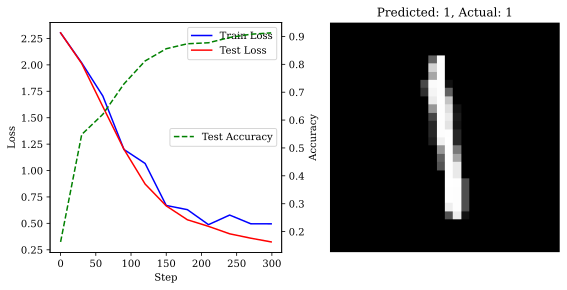

In [3]:
# Data
BATCH_SIZE = 64  # Batch size for training and testing

key = jax.random.PRNGKey(0)  # Random key for reproducibility

# Data normalization and transformation
normalise_data = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST("MNIST", train=True, download=True, transform=normalise_data)
test_dataset = torchvision.datasets.MNIST("MNIST", train=False, download=True, transform=normalise_data)

# Data loaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model
class CNN(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        # Standard CNN setup: convolutional layer, followed by flattening, with a small MLP on top.
        self.layers = [
            eqx.nn.Conv2d(1, 3, kernel_size=4, key=key1),
            eqx.nn.MaxPool2d(kernel_size=2),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(1728, 512, key=key2),
            jax.nn.sigmoid,
            eqx.nn.Linear(512, 64, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(64, 10, key=key4),
            jax.nn.log_softmax,
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        return x

key, subkey = jax.random.split(key, 2)
model = CNN(subkey)

# Loss & Inference & Evaluation
@eqx.filter_jit
def loss(model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, "batch"]) -> Float[Array, ""]:
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y)

def cross_entropy(y: Int[Array, "batch"], pred_y: Float[Array, "batch 10"]) -> Float[Array, ""]:
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)

@eqx.filter_jit
def compute_accuracy(model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, "batch"]) -> Float[Array, ""]:
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)

def evaluate(model: CNN, testloader: torch.utils.data.DataLoader):
    avg_loss, avg_acc = 0, 0
    for x, y in testloader:
        avg_loss += loss(model, x.numpy(), y.numpy())
        avg_acc += compute_accuracy(model, x.numpy(), y.numpy())
    return avg_loss / len(testloader), avg_acc / len(testloader)

# Training
STEPS = 300  # Number of training steps
PRINT_EVERY = 30  # Print every 30 steps
LEARNING_RATE = 3e-4  # Learning rate

optim = optax.adamw(LEARNING_RATE)  # Adam optimizer with weight decay

def train(model, trainloader, testloader, optim, steps, print_every):
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(model: CNN, opt_state: PyTree, x: Float[Array, "batch 1 28 28"], y: Int[Array, "batch"]):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    # Loop over our training dataset as many times as we need.
    def infinite_trainloader():
        while True:
            yield from trainloader

    lsteps, train_losses, test_losses, test_accuracies = [], [], [], []

    for step, (x, y) in zip(range(steps), infinite_trainloader()):
        # PyTorch dataloaders give PyTorch tensors by default, so convert them to NumPy arrays.
        x, y = x.numpy(), y.numpy()

        model, opt_state, train_loss = make_step(model, opt_state, x, y)

        if (step % print_every) == 0 or (step == steps - 1):
            test_loss, test_accuracy = evaluate(model, testloader)
            lsteps.append(step)
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            test_accuracies.append(test_accuracy.item())
            print(f"{step=}, train_loss={train_loss.item()}, test_loss={test_loss.item()}, test_accuracy={test_accuracy.item()}")

    return model, lsteps, train_losses, test_losses, test_accuracies

model, lsteps, train_losses, test_losses, test_accuracies = train(model, trainloader, testloader, optim, STEPS, PRINT_EVERY)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

# Plot training and testing loss in the first subplot
axs[0].plot(lsteps, train_losses, 'b-', label='Train Loss')
axs[0].plot(lsteps, test_losses, 'r-', label='Test Loss')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot testing accuracy in the second subplot
ax0 = axs[0].twinx()
ax0.plot(lsteps, test_accuracies, 'g--', label='Test Accuracy')
ax0.set_xlabel('Step')
ax0.set_ylabel('Accuracy')
ax0.legend(loc='center right')

# Plot a sample from the MNIST dataset in the third subplot
sample_x, sample_y = next(iter(testloader))
sample_x, sample_y = sample_x.numpy()[0], sample_y.numpy()[0]
sample_pred_y = model(sample_x).argmax()
axs[1].imshow(sample_x.squeeze(), cmap='gray')
axs[1].set_title(f'Predicted: {sample_pred_y}, Actual: {sample_y}')
axs[1].axis('off')

plt.show()

# Residual Networks: Addressing the Vanishing Gradient Problem

Residual Networks (ResNets) are a class of deep neural network architectures that have significantly advanced the field of deep learning. They enable the training of much deeper networks by effectively mitigating issues like vanishing and exploding gradients. This comprehensive explanation covers the challenges associated with training deep networks, the concept of residual blocks, the role of batch normalization, and how these elements contribute to smoother loss surfaces and improved network performance.

## The Vanishing and Exploding Gradient Problem

### Understanding Gradients in Deep Networks

In neural networks, training involves adjusting the network's weights to minimize a loss function that measures the difference between predicted outputs and actual targets. This adjustment relies on gradients—partial derivatives of the loss function with respect to each weight—calculated through backpropagation. Gradients indicate the direction and magnitude by which weights should be updated to reduce the loss.

### Vanishing Gradients

In very deep networks, gradients computed for earlier layers can become exceedingly small, effectively vanishing. This occurs because backpropagation involves the multiplication of many small derivatives (from activation functions like sigmoid or tanh) as gradients are propagated backward through the network layers. When these derivatives are less than one, their repeated multiplication results in a gradient that approaches zero exponentially with network depth.

**Impact**:
- Early layers learn very slowly or not at all.
- The network struggles to capture low-level features essential for deep learning tasks.
- Training becomes inefficient and may not converge to an optimal solution.

### Exploding Gradients

Conversely, gradients can also become excessively large, or explode, when the derivatives during backpropagation are greater than one. This leads to numerical instability and erratic weight updates, making it difficult for the network to converge.

**Impact**:
- Weight updates become too large, causing the loss function to oscillate or diverge.
- Training may fail entirely due to numerical overflow or instability.

### Shattered Gradients Phenomenon

In addition to vanishing and exploding gradients, very deep networks can suffer from "shattered gradients," where the gradient mappings become highly irregular. Small changes in inputs or parameters can cause large, unpredictable changes in gradients, making optimization via gradient descent methods challenging.

## Residual Blocks: The Core of Residual Networks

### The Concept of Residual Learning

Residual learning addresses the vanishing gradient problem by allowing layers to learn modifications (residuals) to the identity mapping rather than complete transformations. Instead of each layer attempting to learn a direct mapping $ \mathcal{H}(\mathbf{x}) $ of the input $ \mathbf{x} $, it learns a residual function $ \mathcal{F}(\mathbf{x}) = \mathcal{H}(\mathbf{x}) - \mathbf{x} $, or equivalently, $ \mathcal{H}(\mathbf{x}) = \mathbf{x} + \mathcal{F}(\mathbf{x}) $.

### Structure of a Residual Block

A residual block typically consists of:

- **Convolutional Layers**: One or more layers that process the input to produce an intermediate output.
- **Shortcut Connection (Skip Connection)**: A direct path that adds the input $ \mathbf{x} $ to the output of the convolutional layers.
- **Activation Function**: Applied after the addition to introduce non-linearity.

The output of a residual block is:

$$
\mathbf{y} = \mathbf{x} + \mathcal{F}(\mathbf{x}, \{W_i\})
$$

where $ \mathcal{F} $ represents the residual function learned by the convolutional layers with weights $ \{W_i\} $.

### Benefits of Residual Blocks

1. **Improved Gradient Flow**: Skip connections provide alternate paths for gradients to backpropagate, mitigating the vanishing gradient problem.

2. **Ease of Optimization**: Learning residuals simplifies the optimization process, as it is often easier to learn the residual mapping $ \mathcal{F}(\mathbf{x}) $ than the original mapping $ \mathcal{H}(\mathbf{x}) $.

3. **Identity Mapping**: If the optimal mapping is an identity function, residual blocks can easily approximate it by driving $ \mathcal{F}(\mathbf{x}) $ to zero.

4. **Deep Network Training**: Residual blocks enable the training of much deeper networks (e.g., over 100 layers) without performance degradation.

### Understanding Residual Blocks as Ensembles

Residual networks can be viewed as ensembles of networks of varying depths. The skip connections allow the network to combine outputs from multiple paths, effectively integrating features learned at different levels.

## Batch Normalization: Stabilizing Deep Network Training

### The Need for Batch Normalization

As networks deepen, they become more sensitive to the initialization of weights and the distribution of inputs to each layer. Internal covariate shift—changes in the distribution of layer inputs during training—can slow down training and require careful weight initialization and low learning rates.

### How Batch Normalization Works

Batch normalization standardizes the inputs to each layer by adjusting and scaling the activations:

1. **Compute Mean and Variance**:

   For each feature over a mini-batch $ B $:

   $$
   \mu_B = \frac{1}{m} \sum_{i=1}^{m} h_i, \quad \sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m} (h_i - \mu_B)^2
   $$

2. **Normalize**:

   $$
   \hat{h}_i = \frac{h_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
   $$

   where $ \epsilon $ is a small constant to prevent division by zero.

3. **Scale and Shift**:

   Introduce learnable parameters $ \gamma $ and $ \beta $ to allow the network to restore the original distribution if needed:

   $$
   h_i^{\text{BN}} = \gamma \hat{h}_i + \beta
   $$

### Benefits of Batch Normalization

1. **Accelerated Training**: Allows for higher learning rates by reducing the risk of exploding gradients.

2. **Reduced Sensitivity to Initialization**: Less dependence on careful weight initialization, making the network more robust.

3. **Regularization Effect**: Acts as a form of regularization by adding noise to the activations due to batch statistics, potentially reducing overfitting.

4. **Stabilized Activations**: Maintains consistent distributions of layer inputs, which helps in training very deep networks.

## Combining Residual Blocks and Batch Normalization

### Addressing Vanishing and Exploding Gradients

- **Residual Blocks**: Mitigate vanishing gradients by providing direct pathways for gradient flow, ensuring that earlier layers receive sufficient gradient signals.
- **Batch Normalization**: Addresses exploding gradients by normalizing activations, keeping them within a stable range and preventing large updates.

### Smoother Loss Surface

Both residual connections and batch normalization contribute to a smoother loss surface:

- **Residual Connections**: Simplify the loss landscape by allowing the network to learn identity mappings more easily and by reducing the depth that gradients need to traverse without attenuation.
- **Batch Normalization**: Ensures that the activation distributions remain stable across layers and iterations, smoothing the optimization landscape.

A smoother loss surface facilitates more effective optimization, allowing gradient descent algorithms to find better minima more reliably.

## Practical Insights into Residual Networks

### Training Very Deep Networks

Residual networks enable the training of networks with significantly more layers than previously possible. For example, ResNets with 50, 101, or even 152 layers have been successfully trained and have achieved state-of-the-art performance on various tasks.

### Performance Improvements

- **Image Classification**: ResNets have achieved top results on datasets like ImageNet and CIFAR-10.
- **Object Detection and Segmentation**: Deeper residual networks improve feature representation, benefiting tasks requiring detailed understanding of images.
- **Transfer Learning**: Pre-trained ResNets serve as powerful feature extractors for various downstream applications.

### Architectural Variations

- **Bottleneck Blocks**: Introduce a three-layer block with $ 1 \times 1 $, $ 3 \times 3 $, and $ 1 \times 1 $ convolutions to reduce computation while maintaining depth.
- **Identity vs. Projection Shortcuts**: When the dimensions of input and output differ, projection shortcuts (using $ 1 \times 1 $ convolutions) adjust dimensions to enable addition.
- **Pre-Activation ResNets**: Modify the order of operations within a residual block (batch normalization and activation before convolution) to improve gradient flow.

## Theoretical Understanding

### Why Residual Networks Work

1. **Identity Paths**: The skip connections create paths in the network where information and gradients can flow without attenuation, effectively creating an ensemble of shallower networks within the deep architecture.

2. **Ease of Learning**: Learning residuals is theoretically easier than learning unreferenced functions because the network can focus on learning the changes required from the identity mapping.

3. **Linear Behavior**: In the extreme case where residual functions are zero, the network behaves like an identity function, which is easy to optimize and serves as a good initialization point.

### Limitations and Considerations

- **Overfitting**: Deeper networks have more parameters and may overfit if not properly regularized.
- **Computational Resources**: Very deep networks require significant computational power and memory.

## Implementation Guidelines

### Weight Initialization

- **He Initialization**: Initialize weights to account for ReLU activations, helping to maintain variance through layers.
- **Zero Initialization of Last Layer in Residual Block**: Initializing the last layer of a residual block to zero can help the network start as an identity function, which can improve training stability.

### Learning Rate and Optimization

- **Learning Rate Schedules**: Use learning rate decay strategies to improve convergence.
- **Optimizers**: Adaptive optimizers like Adam can be used, but standard SGD with momentum often works well with batch normalization.

### Regularization Techniques

- **Data Augmentation**: Enhances generalization by increasing the diversity of training data.
- **Dropout**: May not be necessary due to the regularization effect of batch normalization and residual connections.

# Recurrent Neural Networks (RNNs)

Recurrent Neural Networks (RNNs) are a class of neural networks designed to process sequential data by incorporating temporal dependencies. Unlike feedforward neural networks, RNNs maintain a hidden state that captures information about previous inputs, enabling them to model sequences and time-dependent phenomena effectively. This comprehensive explanation covers the fundamentals of RNNs, various architectures for sequence processing, training methodologies, challenges like vanishing and exploding gradients, and advanced units like Gated Recurrent Units (GRU) and Long Short-Term Memory (LSTM) networks.

## Fundamentals of Recurrent Neural Networks

### Sequence Modeling with RNNs

RNNs are particularly suited for tasks where the input data is sequential, and the order of the data points matters. Examples include:

- **Natural Language Processing**: Sentences are sequences of words where context and order are crucial.
- **Time Series Analysis**: Financial data, sensor readings, or any data that varies over time.
- **Speech Recognition**: Audio signals processed over time.

An RNN processes an input sequence $ \mathbf{x}_{1:T} = (\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_T) $ by recursively applying a transition function to update its hidden state $ \mathbf{h}_t $, which serves as a memory of the past inputs.

### The Recurrent Relation

The hidden state at time $ t $ is computed as:

$$
\mathbf{h}_t = f(\mathbf{h}_{t-1}, \mathbf{x}_t; \boldsymbol{\theta})
$$

where:

- $ \mathbf{h}_{t-1} $ is the hidden state from the previous time step.
- $ \mathbf{x}_t $ is the input at time $ t $.
- $ f $ is a nonlinear activation function (e.g., $ \tanh $, ReLU).
- $ \boldsymbol{\theta} $ represents the parameters (weights and biases) of the network.

The output $ \mathbf{y}_t $ at each time step can be computed as:

$$
\mathbf{y}_t = g(\mathbf{h}_t; \boldsymbol{\phi})
$$

where $ g $ is an output function (e.g., a linear transformation followed by a softmax for classification), and $ \boldsymbol{\phi} $ are the output layer parameters.

## Vec2Seq: Sequence Generation

Vec2Seq models map a fixed-length input vector to a variable-length output sequence. They are useful in tasks like:

- **Image Captioning**: Generating a sequence of words (caption) from an image feature vector.
- **Text Generation**: Generating text based on a latent representation.

### Model Architecture

Given an input vector $ \mathbf{x} \in \mathbb{R}^D $, the RNN generates an output sequence $ \mathbf{y}_{1:T} $ by:

1. **Initializing the Hidden State**:

   $$
   \mathbf{h}_0 = \phi_{\text{init}}(\mathbf{x})
   $$

   where $ \phi_{\text{init}} $ is a function that initializes the hidden state based on the input vector.

2. **Recursively Generating Outputs**:

   For $ t = 1 $ to $ T $:

   - **Compute Hidden State**:

     $$
     \mathbf{h}_t = f(\mathbf{h}_{t-1}, \mathbf{y}_{t-1}; \boldsymbol{\theta})
     $$

     where $ \mathbf{y}_{t-1} $ is the output from the previous time step (during training, the actual previous output is used; during inference, the generated output is used).

   - **Generate Output**:

     $$
     \mathbf{y}_t \sim p(\mathbf{y}_t | \mathbf{h}_t)
     $$

     where $ p $ is a probability distribution over possible outputs, often modeled using a softmax function.

### Conditional Generative Modeling

The model defines a conditional probability distribution over sequences:

$$
p(\mathbf{y}_{1:T} | \mathbf{x}) = \prod_{t=1}^T p(\mathbf{y}_t | \mathbf{h}_t)
$$

This captures dependencies between the output tokens, allowing the model to generate coherent sequences.

### Training Objective

The model is trained to maximize the likelihood of the observed sequences in the training data. The loss function is typically the negative log-likelihood:

$$
\mathcal{L} = -\sum_{t=1}^T \log p(\mathbf{y}_t | \mathbf{h}_t)
$$

## Seq2Vec: Sequence Classification

Seq2Vec models map a variable-length input sequence to a fixed-length output vector, suitable for tasks like:

- **Sentiment Analysis**: Classifying the sentiment of a text sequence.
- **Sequence Classification**: Assigning a label to an entire sequence.

### Model Architecture

1. **Encoding the Input Sequence**:

   - **Forward Pass**:

     $$
     \mathbf{h}_t^{\rightarrow} = f_{\text{forward}}(\mathbf{h}_{t-1}^{\rightarrow}, \mathbf{x}_t)
     $$

   - **Backward Pass** (for bidirectional RNNs):

     $$
     \mathbf{h}_t^{\leftarrow} = f_{\text{backward}}(\mathbf{h}_{t+1}^{\leftarrow}, \mathbf{x}_t)
     $$

   - **Combined Hidden State**:

     $$
     \mathbf{h}_t = [\mathbf{h}_t^{\rightarrow}; \mathbf{h}_t^{\leftarrow}]
     $$

2. **Pooling**:

   Aggregate the hidden states across time to obtain a fixed-length vector:

   - **Average Pooling**:

     $$
     \overline{\mathbf{h}} = \frac{1}{T} \sum_{t=1}^T \mathbf{h}_t
     $$

   - **Max Pooling**:

     $$
     \overline{\mathbf{h}} = \max_{t} \mathbf{h}_t
     $$

3. **Classification**:

   - Apply a fully connected layer and softmax activation:

     $$
     p(y | \mathbf{x}_{1:T}) = \text{softmax}(\mathbf{W} \overline{\mathbf{h}} + \mathbf{b})
     $$

### Training Objective

The model is trained using a cross-entropy loss between the predicted class probabilities and the true labels.

## Seq2Seq: Sequence Translation

Seq2Seq models map a variable-length input sequence to a variable-length output sequence, potentially of different lengths. They are widely used in:

- **Machine Translation**: Translating sentences from one language to another.
- **Speech Recognition**: Converting audio signals to text sequences.

### Encoder-Decoder Architecture

1. **Encoder**:

   - Processes the input sequence and summarizes it into a context vector.

     For $ t = 1 $ to $ T $:

     $$
     \mathbf{h}_t^{\text{enc}} = f_{\text{enc}}(\mathbf{h}_{t-1}^{\text{enc}}, \mathbf{x}_t)
     $$

   - The context vector $ \mathbf{c} $ can be the final hidden state $ \mathbf{h}_T^{\text{enc}} $ or a combination of all hidden states (e.g., through attention mechanisms).

2. **Decoder**:

   - Generates the output sequence based on the context vector.

     For $ t = 1 $ to $ T' $:

     $$
     \mathbf{h}_t^{\text{dec}} = f_{\text{dec}}(\mathbf{h}_{t-1}^{\text{dec}}, \mathbf{y}_{t-1}, \mathbf{c})
     $$

     $$
     \mathbf{y}_t \sim p(\mathbf{y}_t | \mathbf{h}_t^{\text{dec}})
     $$

### Aligned Case (Sequence Labeling)

In tasks where the input and output sequences are aligned (same length), such as:

- **Part-of-Speech Tagging**
- **Named Entity Recognition**

The model predicts an output at each time step:

$$
p(\mathbf{y}_{1:T} | \mathbf{x}_{1:T}) = \prod_{t=1}^T p(\mathbf{y}_t | \mathbf{h}_t)
$$

where $ \mathbf{h}_t $ depends on $ \mathbf{x}_{1:t} $ or both past and future inputs in bidirectional RNNs.

### Unaligned Case

In tasks where the input and output sequences differ in length, the encoder-decoder framework is used, sometimes enhanced with attention mechanisms to allow the decoder to focus on different parts of the input sequence at each time step.

## Backpropagation Through Time (BPTT)

Training RNNs involves computing gradients of the loss function with respect to the network parameters, which requires backpropagating errors through time.

### Unfolding the Network

An RNN can be unfolded over time to represent the sequential dependencies explicitly. Each time step is treated as a layer in a deep network, sharing parameters across time.

### Computing Gradients

The gradient of the loss $ \mathcal{L} $ with respect to the parameters $ \boldsymbol{\theta} $ involves summing over time steps:

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}} = \sum_{t=1}^T \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \frac{\partial \mathbf{h}_t}{\partial \boldsymbol{\theta}}
$$

This recursive dependency requires careful computation, as errors must be propagated back through all previous time steps.

### Truncated BPTT

Due to computational constraints and vanishing gradients over long sequences, BPTT is often truncated to a fixed number of time steps $ K $:

- Only backpropagate errors for $ K $ steps.
- Helps manage memory and computational resources.
- May limit the ability to capture long-term dependencies.

## Vanishing and Exploding Gradients

### The Problem

- **Vanishing Gradients**: Gradients diminish exponentially as they are backpropagated through many time steps, hindering the learning of long-range dependencies.
- **Exploding Gradients**: Gradients can grow exponentially, leading to numerical instability and difficulty in convergence.

### Causes

- Repeated multiplication by weights and activation derivatives less than or greater than one.
- The eigenvalues (spectral radius) of the recurrent weight matrix influence the gradient behavior.

### Mitigation Strategies

1. **Gradient Clipping**:

   - Limit the gradient norms to prevent explosion.
   - For gradient $ \mathbf{g} $:

     $$
     \mathbf{g} \leftarrow \mathbf{g} \cdot \min\left(1, \frac{\tau}{\|\mathbf{g}\|}\right)
     $$

     where $ \tau $ is a threshold.

2. **Weight Initialization**:

   - Initialize weights to ensure that the initial spectral radius is close to one.

3. **Regularization Techniques**:

   - L1 or L2 regularization to penalize large weights.

4. **Advanced RNN Units**:

   - Use architectures like GRU or LSTM that are designed to handle these issues.

## Gating Mechanisms and Long-Term Memory

To address the limitations of standard RNNs in capturing long-term dependencies, gating mechanisms are introduced to control the flow of information.

### Gated Recurrent Units (GRU)

GRUs are a type of RNN that uses gating mechanisms to regulate information flow without separate memory cells.

#### Components

1. **Reset Gate ($ \mathbf{r}_t $)**:

   - Determines how to combine the new input with the previous memory.

   $$
   \mathbf{r}_t = \sigma(\mathbf{W}_r \mathbf{x}_t + \mathbf{U}_r \mathbf{h}_{t-1} + \mathbf{b}_r)
   $$

2. **Update Gate ($ \mathbf{z}_t $)**:

   - Controls how much of the previous memory to keep.

   $$
   \mathbf{z}_t = \sigma(\mathbf{W}_z \mathbf{x}_t + \mathbf{U}_z \mathbf{h}_{t-1} + \mathbf{b}_z)
   $$

3. **Candidate Activation ($ \tilde{\mathbf{h}}_t $)**:

   - Proposed new memory content.

   $$
   \tilde{\mathbf{h}}_t = \tanh(\mathbf{W}_h \mathbf{x}_t + \mathbf{U}_h (\mathbf{r}_t \odot \mathbf{h}_{t-1}) + \mathbf{b}_h)
   $$

4. **Final Memory at Time $ t $ ($ \mathbf{h}_t $)**:

   - Combines the previous memory and the candidate activation.

   $$
   \mathbf{h}_t = (1 - \mathbf{z}_t) \odot \mathbf{h}_{t-1} + \mathbf{z}_t \odot \tilde{\mathbf{h}}_t
   $$

#### Advantages

- **Simpler Structure**: Fewer gates than LSTM, making it computationally efficient.
- **Capability**: Effectively captures dependencies over long sequences.

### Long Short-Term Memory (LSTM)

LSTMs introduce memory cells and multiple gates to regulate the flow of information, specifically designed to overcome vanishing gradient problems.

#### Components

1. **Input Gate ($ \mathbf{i}_t $)**:

   - Controls the extent to which new information flows into the cell.

   $$
   \mathbf{i}_t = \sigma(\mathbf{W}_i \mathbf{x}_t + \mathbf{U}_i \mathbf{h}_{t-1} + \mathbf{b}_i)
   $$

2. **Forget Gate ($ \mathbf{f}_t $)**:

   - Determines what information to discard from the cell.

   $$
   \mathbf{f}_t = \sigma(\mathbf{W}_f \mathbf{x}_t + \mathbf{U}_f \mathbf{h}_{t-1} + \mathbf{b}_f)
   $$

3. **Output Gate ($ \mathbf{o}_t $)**:

   - Controls the output of the cell to the hidden state.

   $$
   \mathbf{o}_t = \sigma(\mathbf{W}_o \mathbf{x}_t + \mathbf{U}_o \mathbf{h}_{t-1} + \mathbf{b}_o)
   $$

4. **Cell Candidate ($ \tilde{\mathbf{c}}_t $)**:

   - New candidate values for the cell state.

   $$
   \tilde{\mathbf{c}}_t = \tanh(\mathbf{W}_c \mathbf{x}_t + \mathbf{U}_c \mathbf{h}_{t-1} + \mathbf{b}_c)
   $$

5. **Cell State Update ($ \mathbf{c}_t $)**:

   - Updates the cell state by combining previous state and candidate.

   $$
   \mathbf{c}_t = \mathbf{f}_t \odot \mathbf{c}_{t-1} + \mathbf{i}_t \odot \tilde{\mathbf{c}}_t
   $$

6. **Hidden State ($ \mathbf{h}_t $)**:

   - Computes the hidden state based on the cell state.

   $$
   \mathbf{h}_t = \mathbf{o}_t \odot \tanh(\mathbf{c}_t)
   $$

#### Advantages

- **Long-Term Dependencies**: Capable of learning dependencies over long sequences.
- **Flexible Memory**: The cell state acts as an explicit memory, modulated by gates.

## Practical Considerations

- **Initialization**: Proper weight initialization can improve convergence.
- **Regularization**: Techniques like dropout (applied to recurrent connections) can prevent overfitting.
- **Optimization Algorithms**: Adaptive optimizers like Adam are commonly used.
- **Sequence Padding**: Handle variable-length sequences by padding and masking.
- **Batch Processing**: Efficient batching requires careful handling of sequences of different lengths.

By mastering these concepts and techniques, one can effectively design and train RNNs to model complex sequential data.

step=0, loss=0.6979988217353821
step=50, loss=0.689518928527832
step=100, loss=0.695279598236084
step=150, loss=0.04843534156680107


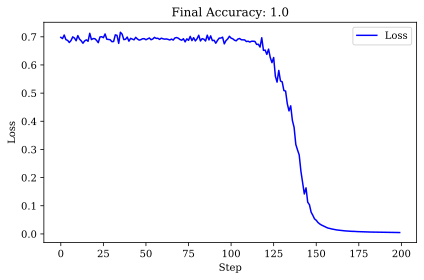

In [4]:
# Classify clockwise vs anticlockwise spirals

def dataloader(arrays, batch_size):
    """
    Custom data loader that yields batches of data.
    
    Parameters:
    arrays : tuple of arrays
        The data arrays to be batched.
    batch_size : int
        The size of each batch.
    
    Yields:
    tuple of arrays
        Batches of data.
    """
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

def get_data(dataset_size, *, key):
    """
    Generate spiral data for classification.
    
    Parameters:
    dataset_size : int
        The size of the dataset.
    key : jax.random.PRNGKey
        Random key for reproducibility.
    
    Returns:
    tuple of arrays
        The generated data and labels.
    """
    t = jnp.linspace(0, 2 * jnp.pi, 16)
    offset = random.uniform(key, (dataset_size, 1), minval=0, maxval=2 * jnp.pi)
    x1 = jnp.sin(t + offset) / (1 + t)
    x2 = jnp.cos(t + offset) / (1 + t)
    y = jnp.ones((dataset_size, 1))

    half_dataset_size = dataset_size // 2
    x1 = x1.at[:half_dataset_size].multiply(-1)
    y = y.at[:half_dataset_size].set(0)
    x = jnp.stack([x1, x2], axis=-1)

    return x, y

class RNN(eqx.Module):
    hidden_size: int
    cell: eqx.Module
    linear: eqx.nn.Linear
    bias: jax.Array

    def __init__(self, in_size, out_size, hidden_size, *, key):
        ckey, lkey = random.split(key)
        self.hidden_size = hidden_size
        self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=ckey)
        self.linear = eqx.nn.Linear(hidden_size, out_size, use_bias=False, key=lkey)
        self.bias = jnp.zeros(out_size)

    def __call__(self, input):
        hidden = jnp.zeros((self.hidden_size,))

        def f(carry, inp):
            return self.cell(inp, carry), None

        out, _ = lax.scan(f, hidden, input)
        # sigmoid because we're performing binary classification
        return jax.nn.sigmoid(self.linear(out) + self.bias)
    
@eqx.filter_value_and_grad
def compute_loss(model, x, y):
    pred_y = jax.vmap(model)(x)
    return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))

@eqx.filter_jit
def make_step(model, x, y, opt_state):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

# Parameters
depth = 1
seed = 5678
steps = 200
batch_size = 32
hidden_size = 16
dataset_size = 10000
learning_rate = 3e-3

# Generate data
data_key, model_key = random.split(random.PRNGKey(seed), 2)
xs, ys = get_data(dataset_size, key=data_key)
iter_data = dataloader((xs, ys), batch_size)

# Initialize model and optimizer
model = RNN(in_size=2, out_size=1, hidden_size=hidden_size, key=model_key)
optim = optax.adam(learning_rate)
opt_state = optim.init(model)

# Initialize lists to store loss values and prediction data
losses, pred_ys_list = [], []

# Training loop
for step, (x, y) in zip(range(steps), iter_data):
    loss, model, opt_state = make_step(model, x, y, opt_state)
    losses.append(loss.item())
    if step % 50 == 0:
        print(f"step={step}, loss={loss.item()}")

# Evaluate model
pred_ys = jax.vmap(model)(xs)
pred_ys_list.append(pred_ys)
num_correct = jnp.sum((pred_ys > 0.5) == ys)

# Plotting
fig, axs = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
axs.plot(range(steps), losses, 'b-', label='Loss')
axs.set_xlabel('Step')
axs.set_ylabel('Loss')
axs.legend()
axs.set_title(f"Final Accuracy: {(num_correct / dataset_size).item()}")

plt.show()

### Transformers: An Overview

Transformers are a type of neural network architecture that uses a mechanism called **attention**, which allows the model to focus on different parts of the input data by assigning varying weights to different elements. Unlike traditional models, these weights are determined based on the input itself, creating flexible, context-dependent representations. Transformers "transform" input vectors into a new set of vectors in a different space that is better suited for solving complex tasks, like translation or question-answering. 

The key advantages of transformers include:

1. **Parallelization**: Transformers are highly compatible with parallel processing on GPUs, allowing large models with trillions of parameters to be trained efficiently.
2. **Transfer Learning**: Transformers can be trained on a broad dataset and then fine-tuned on specific tasks, enabling effective transfer learning. Large, general-purpose models created this way are called **foundation models** because they serve as adaptable bases for various applications.
3. **Self-Supervised Learning**: Transformers can learn patterns in vast amounts of unlabelled data, such as text from the internet, making them suitable for tasks like language modeling.

Transformers were initially designed for language processing tasks, which share some characteristics with image processing, such as:

- **High dimensionality**: The input data has many variables (e.g., words in a sentence or pixels in an image).
- **Consistency in Statistics**: The statistical properties remain similar across different parts (e.g., word meaning doesn’t change based on position).

A unique challenge in language data is that text sequences vary in length, which transformers manage through a mechanism called **attention**.

### The Attention Mechanism

The attention mechanism is the core of the transformer and operates as follows:

1. **Input Representation**: The input is represented as a matrix, $ \mathbf{X} $, where each column is an individual input vector. The matrix is of size $ D \times N $, where $ D $ is the dimensionality of each vector and $ N $ is the number of inputs.

2. **Defining Queries, Keys, and Values**: Three matrices — the query $ \mathbf{Q} $, the key $ \mathbf{K} $, and the value $ \mathbf{V} $ — are derived from the input:
   $$
   \mathbf{Q} = \mathbf{W}_q \mathbf{X}, \quad \mathbf{K} = \mathbf{W}_k \mathbf{X}, \quad \mathbf{V} = \mathbf{W}_v \mathbf{X}
   $$
   where $ \mathbf{W}_q $, $ \mathbf{W}_k $, and $ \mathbf{W}_v $ are learned weight matrices.

3. **Calculating Attention Weights**: The model computes the similarity between queries and keys through inner products. A **softmax** function is then applied to normalize these similarities into attention weights:
   $$
   \mathbf{A} = \text{Softmax}(\mathbf{K}^T \mathbf{Q})
   $$
   Here, the attention weights determine how much focus each input (key) should receive relative to the query.

4. **Output Calculation**: The attention weights are used to combine the values:
   $$
   \mathbf{Sa} = \mathbf{V} \, \text{Softmax}(\mathbf{K}^T \mathbf{Q})
   $$
   This weighted sum forms the final output of the attention mechanism, reflecting the model’s focus on various input elements based on the context.

The attention mechanism is nonlinear due to the softmax operation, making it capable of capturing complex patterns. Since it relies on a shared set of weights, it can handle varying sequence lengths and scales efficiently.

### Extensions to Attention

Three common extensions enhance the attention mechanism in transformers:

1. **Positional Encoding**: Since attention itself doesn’t account for word order, positional encodings are added to preserve sequence information. These can be absolute (added to the input vectors) or relative (applied to the attention weights).

2. **Scaled Attention**: To avoid issues where large inner products overpower the softmax function and slow down training, the inner products are scaled by the square root of the query dimension $ D_q $:
   $$
   \mathbf{Sa}[\mathbf{X}] = \mathbf{V} \, \text{Softmax} \left( \frac{\mathbf{K}^T \mathbf{Q}}{\sqrt{D_q}} \right)
   $$

3. **Multi-Head Attention**: In practice, multiple attention mechanisms (called heads) operate in parallel, each with its own set of $ \mathbf{Q} $, $ \mathbf{K} $, and $ \mathbf{V} $ matrices. These outputs are combined through a final linear transformation, allowing the model to capture diverse relationships in the data.

### Transformer Architecture

The core of a transformer is a **multi-head self-attention unit** followed by a **fully connected feed-forward network**. The structure enables words or tokens to interact with each other through attention and then apply nonlinear transformations independently. This structure is repeated in layers to build deep representations.

Each layer includes:

1. **Multi-Head Attention**: The word representations interact through multi-head attention, and the output is combined with the input using a residual connection.
2. **Layer Normalization**: Similar to batch normalization, but using statistics from each sequence, it improves model stability and convergence.
3. **Feed-Forward Network**: A fully connected network operates separately on each token, adding more representation power.

With multiple stacked layers, transformers can learn intricate dependencies and capture diverse language structures, making them effective for many natural language processing tasks.

### Graph Neural Networks (GNNs): An Overview

Graphs are highly flexible structures consisting of **nodes** (or vertices) connected by **edges** (or links). They are commonly used to model complex relationships in various domains, from social networks to biological systems. Graphs are often sparse, meaning only a small subset of possible connections between nodes exists.

Some common types of graphs include:
1. **Social Networks**: Represented as undirected graphs where connections between nodes (people) are symmetric.
2. **Citation Networks**: Directed graphs where one paper cites another, creating asymmetric relationships.
3. **Knowledge Graphs**: Directed multigraphs where nodes can represent various types of entities (people, places) with multiple edges denoting different relationships.
4. **Geometric Graphs**: Represent a set of points in a 3D space connected based on proximity.
5. **Hierarchical Graphs**: Represent complex structures where subgraphs represent parts of an overall system, such as objects in a scene.

Working with graphs introduces unique challenges:
- **Variable topology**: Graph structures vary widely, making it difficult to design expressive models that handle this variation.
- **Large scale**: Graphs can be massive, as in social networks with billions of nodes.
- **Single-instance training**: Often, there is only one large graph available, making standard training/testing splits less feasible.

### Representing Graphs Mathematically

Graphs are represented with matrices to capture node features and relationships:
- **Adjacency Matrix** $ \mathbf{A} $: A binary matrix where element $ (m, n) $ is 1 if there is an edge between nodes $ m $ and $ n $.
- **Node Data Matrix** $ \mathbf{X} $: Stores feature vectors for each node.
- **Edge Data Matrix** $ \mathbf{E} $: Stores feature vectors for each edge.

The adjacency matrix provides information about connectivity patterns, where powers of $ \mathbf{A} $ reveal multi-step connections. For instance, $ \mathbf{A}^2 $ indicates paths of length two between nodes.

### Graph Neural Network Tasks

GNNs are designed for tasks such as:
- **Graph Classification**: Aggregates node features into a single vector to classify the entire graph.
- **Node Classification**: Predicts labels for individual nodes based on their local neighborhood and global graph context.
- **Edge Prediction**: Estimates the probability of missing edges, often used for link prediction tasks.

### Graph Convolutional Networks (GCNs)

GCNs are a popular type of GNN that use convolution-like operations to process graph data. They apply a function $ \mathbf{F} $ that aggregates information from each node's neighbors, creating new node embeddings layer by layer. This aggregation process creates a **relational inductive bias**, focusing the model on information from neighboring nodes.

Each layer of a GCN can be represented as:
$$
\mathbf{H}_{k+1} = \mathbf{F}\left(\mathbf{H}_k, \mathbf{A}, \phi_k\right),
$$
where:
- $ \mathbf{H}_k $ denotes node embeddings at layer $ k $.
- $ \mathbf{A} $ is the adjacency matrix.
- $ \phi_k $ represents learned parameters for layer $ k $.

The layers successively refine node embeddings, gathering information from increasingly larger neighborhoods.

### Key Properties of GNNs

1. **Permutation Invariance**: Since the order of nodes is arbitrary, GNN layers must be **equivariant** to permutations. This means that if node indices are reordered, the resulting node embeddings should also reorder in the same way, preserving the overall structure.

2. **Parameter Sharing**: GNNs use shared parameters across nodes, reducing the number of parameters required and allowing generalization to different graphs with similar structures.

3. **Inductive vs. Transductive Learning**:
   - **Inductive**: Involves training on multiple graphs and generalizing to new, unseen graphs.
   - **Transductive**: Operates on a single large graph where some nodes are labeled during training, and the model learns to predict labels for other nodes in the same graph.

### Receptive Fields in GNNs

The concept of **receptive fields** in GNNs is analogous to CNNs. Each node’s receptive field grows with each layer, gathering information from nodes within an increasing number of “hops.” For instance, in a 2-layer GCN, a node’s receptive field would include all nodes within a two-hop neighborhood, effectively capturing local structure around each node.

### Equivariance and Invariance in GNNs

For GNNs to respect the arbitrary ordering of nodes:
- **Equivariance**: Each layer must respect permutations in the node order.
- **Invariance**: For graph-level tasks, the final output should be invariant to node order since the overall structure, not individual node positions, is important.

### Graph Neural Network Applications

GNNs have broad applications in areas like social network analysis, recommendation systems, molecular graph analysis, and knowledge representation. By efficiently processing complex graph structures, GNNs enable powerful insights and predictions on various types of relational data.

In [5]:
class GCNLayer(nn.Module):
    c_out: int  # Output feature size

    @nn.compact
    def __call__(self, node_feats, adj_matrix):
        """
        Graph Convolutional Network (GCN) layer.
        
        Inputs:
            node_feats - Array with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(axis=-1, keepdims=True)
        
        # Linear transformation of node features
        node_feats = nn.Dense(features=self.c_out, name='projection')(node_feats)
        
        # Aggregation of neighboring node features
        node_feats = jax.lax.batch_matmul(adj_matrix, node_feats)
        
        # Normalization by the number of neighbors
        node_feats = node_feats / num_neighbours
        
        return node_feats

# Example input features and adjacency matrix
node_feats = jnp.arange(8, dtype=jnp.float32).reshape((1, 4, 2))
adj_matrix = jnp.array([[[1, 1, 0, 0],
                         [1, 1, 1, 1],
                         [0, 1, 1, 1],
                         [0, 1, 1, 1]]]).astype(jnp.float32)

# Initialize the GCN layer
layer = GCNLayer(c_out=2)

# Define custom parameters instead of using random initialization
params = {'projection': {
          'kernel': jnp.array([[1., 0.], [0., 1.]]),
          'bias'  : jnp.array([0., 0.])}}

# Apply the GCN layer to the input features and adjacency matrix
out_feats = layer.apply({'params': params}, node_feats, adj_matrix)

# Print the results
print("Adjacency matrix: \n", adj_matrix)
print("Input features: \n", node_feats)
print("Output features: \n", out_feats)

Adjacency matrix: 
 [[[1. 1. 0. 0.]
  [1. 1. 1. 1.]
  [0. 1. 1. 1.]
  [0. 1. 1. 1.]]]
Input features: 
 [[[0. 1.]
  [2. 3.]
  [4. 5.]
  [6. 7.]]]
Output features: 
 [[[1. 2.]
  [3. 4.]
  [4. 5.]
  [4. 5.]]]


### Bayesian Neural Networks (BNNs)

In traditional deep neural networks (DNNs), the model is usually trained to find a single set of parameters by optimizing a maximum likelihood objective. However, this approach overlooks the fact that a single parameter setting is only one of many that could fit the training data well. Different parameter settings can lead to different generalization behaviors. Bayesian Neural Networks (BNNs) address this by averaging over possible parameter configurations to improve both accuracy and uncertainty estimation, a process known as **Bayesian model averaging**. This averaging produces the **posterior predictive distribution**:
$$
p(\boldsymbol{y} \mid \boldsymbol{x}, \mathcal{D}) = \int p(\boldsymbol{y} \mid \boldsymbol{x}, \boldsymbol{\theta}) p(\boldsymbol{\theta} \mid \mathcal{D}) \, d \boldsymbol{\theta}
$$
where $ p(\boldsymbol{\theta} \mid \mathcal{D}) $ is the posterior over parameters, obtained by combining a prior $ p(\boldsymbol{\theta}) $ and the likelihood of the data $ p(\mathcal{D} \mid \boldsymbol{\theta}) $.

**Challenges in BNNs**: Applying Bayesian inference to neural networks involves two main difficulties:
1. **Specifying Priors**: Selecting suitable prior distributions over parameters.
2. **Posterior Computation**: Calculating the posterior distribution efficiently, which is challenging due to the high dimensionality of parameters and large datasets. 

BNNs are also a part of the broader area of **Bayesian deep learning (BDL)**, where Bayesian methods help neural networks represent uncertainty. In contrast, **deep Bayesian learning (DBL)** uses deep models to expedite Bayesian inference in classical models, often through variational inference or importance sampling techniques.

### Variational Inference

In **variational inference** for BNNs, we approximate the intractable posterior with a simpler distribution $ q_{\boldsymbol{\psi}}(\boldsymbol{\theta}) $, parameterized by $ \boldsymbol{\psi} $. The aim is to minimize the Kullback-Leibler (KL) divergence between the approximate posterior $ q $ and the true posterior $ p $, by finding the optimal $ \boldsymbol{\psi} $. A common choice for the approximate posterior is a **Gaussian distribution** $ q_{\boldsymbol{\psi}}(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta} \mid \boldsymbol{\mu}, \boldsymbol{\Sigma}) $, allowing the use of the **reparameterization trick** to estimate gradients for the **evidence lower bound (ELBO)**, an objective used in variational inference. Although Gaussian approximations are often used, they can differ significantly from other approximations like the Laplace approximation.

### Markov Chain Monte Carlo (MCMC) Methods

MCMC methods, like **Hamiltonian Monte Carlo (HMC)**, can approximate the posterior in BNNs without strong assumptions about its shape. This is considered the gold standard for BNNs, as it theoretically provides a faithful representation of the posterior distribution. However, traditional MCMC methods are computationally intensive, as they need to process the entire dataset at each step. To address this, **Stochastic Gradient MCMC** methods, such as **Stochastic Gradient Langevin Dynamics (SGLD)**, use mini-batches to improve scalability. However, as model complexity and depth increase, MCMC approaches, including stochastic variants, can become prohibitively slow.

### Active Learning (AL)

**Active Learning (AL)** is a semi-supervised approach that allows the model to **query for new labels** from a user or oracle selectively. Its purpose is to achieve high accuracy with fewer labeled data points by targeting the most informative samples for labeling. This is particularly useful in applications where obtaining labeled data is expensive or time-consuming.

In **Gaussian process (GP) regression**, active learning selects the next data point to label based on the model's uncertainty, measured by the **posterior variance**. The next point is chosen by **maximizing the expected reduction in variance**, effectively refining the model in areas of high uncertainty. This criterion can be expressed as:
$$
\mathbb{E}_{p(\theta)} \left[ \left( \sigma^2(\theta) - \sigma^2(\theta, x) \right)^2 \right]
$$
where $ \sigma^2(\theta) $ is the current posterior variance and $ \sigma^2(\theta, x) $ is the posterior variance after adding a new data point $ x $. This formulation prioritizes points that are likely to reduce the overall model uncertainty, leading to more efficient learning.